In [41]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.io import loadmat

In [42]:
%matplotlib inline

In [43]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [44]:
top_k = None 
n_i = 52
n_v = 56
dataset_path = 'hpatches_sequences/hpatches-sequences-release'

In [179]:
methods = ["afnetTFeat", "delf", "disk"]
names = ['afnetTFeat','delf', 'disk']
colors = ['black', 'orange', 'blue']
linestyles = ['-', '-', '-']

In [46]:
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [47]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device

    descriptors_a = descriptors_a.squeeze()
    descriptors_b = descriptors_b.squeeze()
    
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

In [188]:
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in enumerate(seq_names):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

        # IF AFNET
        # keypoints_a = keypoints_a[:,:,:,0]
        # keypoints_a = keypoints_a.squeeze()

        

        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])
        
            # IF AFNET
            # keypoints_b = keypoints_b[:,:,:,0]
            # keypoints_b = keypoints_b.squeeze()

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )
            
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))

            pos_a = keypoints_a[matches[:, 0], : 2]

            pos_a_h = np.concatenate([pos_a, np.ones([matches.shape[0], 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np.transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = keypoints_b[matches[:, 1], : 2]

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(matches.shape[0])
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]

In [85]:
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )
    return n_feats, n_matches

In [50]:
def generate_read_function(method, extension='ppm'):
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if top_k is None:
            return aux['keypoints'], aux['descriptors']
        else:
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
    return read_function

In [51]:

def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    if top_k is None:
        return keypoints, descriptors
    else:
        assert('scores' in mat)
        ids = np.argsort(mat['scores'][0])[-top_k :]
        return keypoints[ids, :], descriptors[ids, :]

In [52]:
if top_k is None:
    cache_dir = 'cache'
else:
    cache_dir = 'cache-top'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [13]:
errors = {}

In [190]:
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        if method == 'delf' or method == 'delf-new':
            read_function = generate_read_function(method, extension='png')
        else:
            read_function = generate_read_function(method)
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])

afnetTFeat
Loading precomputed errors...
# Features: 3819.101852 - [190, 8001]
# Matches: Overall 1396.677778, Illumination 982.211538, Viewpoint 1781.539286
delf
Loading precomputed errors...
# Features: 4608.236111 - [1196, 10939]
# Matches: Overall 1912.400000, Illumination 1973.100000, Viewpoint 1856.035714
disk
# Features: 2021.469136 - [1363, 2024]
# Matches: Overall 1036.287037, Illumination 1192.023077, Viewpoint 891.675000


In [184]:
a = np.load("hpatches_sequences/hpatches-sequences-release/i_ajuntament/1.ppm.disk", allow_pickle=True)
print(a['keypoints'].shape)
print(a['descriptors'].shape)

(2024, 2)
(2024, 128)


In [164]:
with open("image_list_hpatches_sequences.txt", "r") as f:
    image_list = [line.strip() for line in f.readlines()]

image_type = []
for path in image_list:
    type = path.split("/")[2][0]
    image_type.append(type)

image_type = np.array(image_type)

# Features: 3819.101852 - [190, 8001]
# Matches: Overall 1396.677778, Illumination 982.211538, Viewpoint 1781.539286
# Features: 4608.236111 - [1196, 10939]
# Matches: Overall 1912.400000, Illumination 1973.100000, Viewpoint 1856.035714


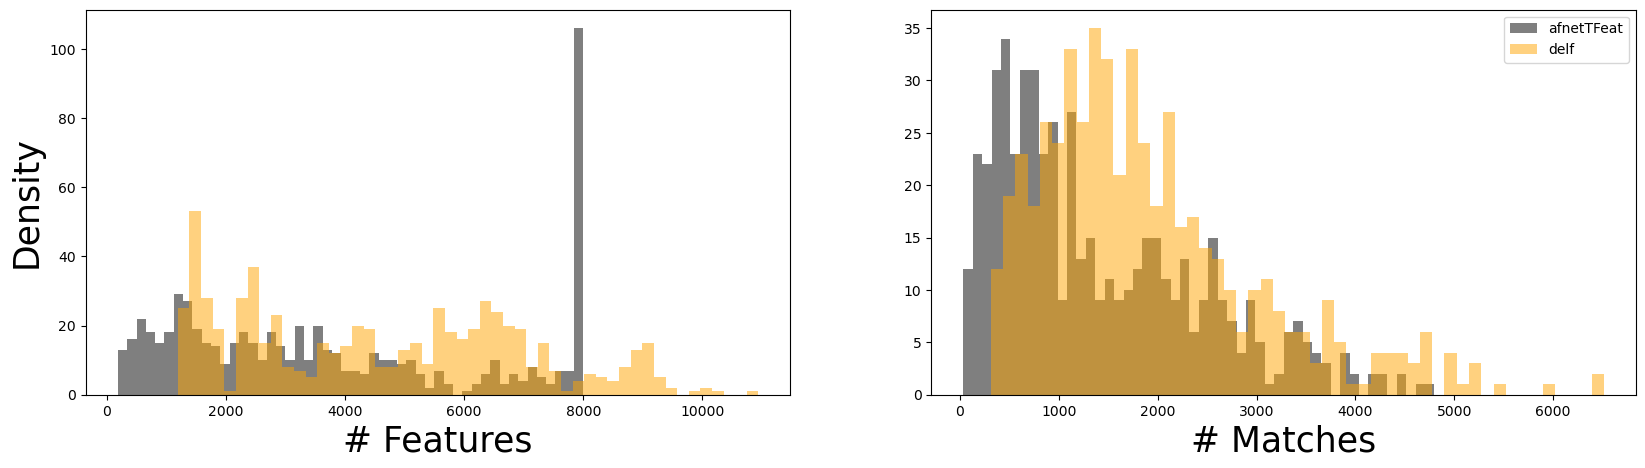

In [167]:
# plot distribution of number of features and feature matches by method and sequence type
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for method, name, color, linestyle in zip(methods, names, colors, linestyles):
    n_feats, n_matches = summary(errors[method][-1])
    ax[0].hist(n_feats, bins=50, density=False, color=color, linestyle=linestyle, alpha=0.5, label=name)
    ax[1].hist(n_matches, bins=50, density=False, color=color, linestyle=linestyle, alpha=0.5, label=name)
ax[0].set_xlabel('# Features')
ax[1].set_xlabel('# Matches')
ax[0].set_ylabel('Density')
ax[1].legend()
plt.show()

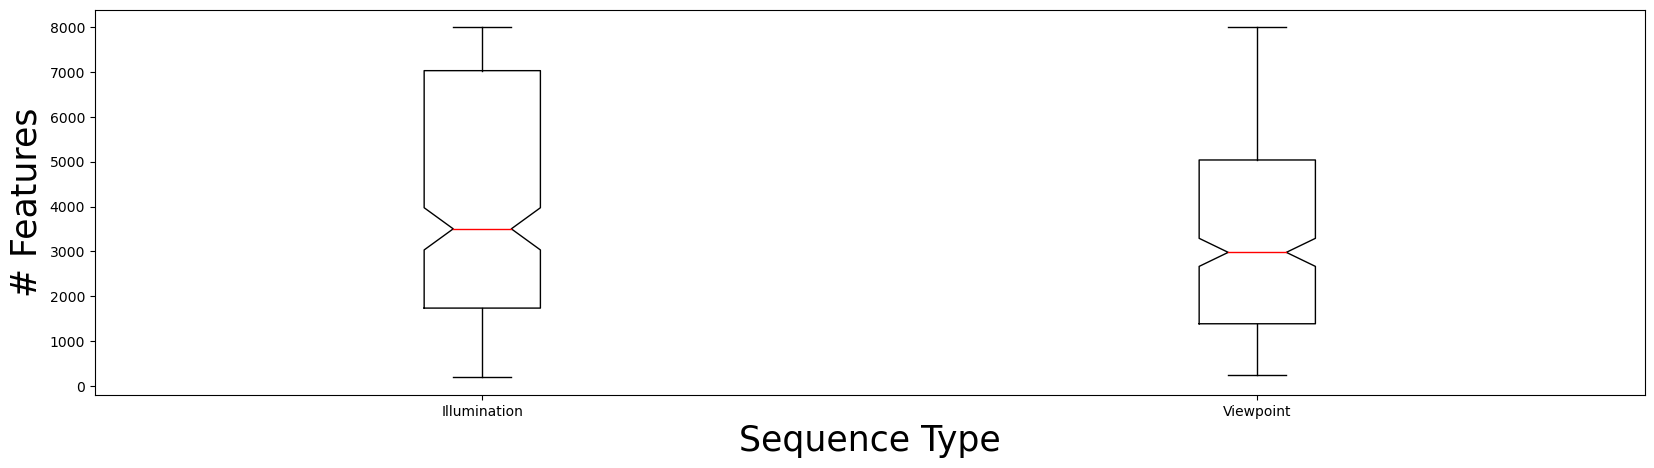

In [178]:
features_afnet = errors["afnetTFeat"][2][1]
matches_afnet = errors["afnetTFeat"][2][2]

# plot distribution of number of features for afnet as boxplot for each sequence type
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.boxplot([features_afnet[image_type == 'i'], features_afnet[image_type == 'v']],
                                labels=['Illumination', 'Viewpoint'],
                     notch=True,  # Show a notch around the median
                     showfliers=True,  # Show outliers
                     showmeans=False,  # Show mean values
                     meanline=False,  # Show a line at the mean
                     medianprops={'color': 'red'})


ax.set_ylabel('# Features')
ax.set_xlabel('Sequence Type')
plt.show()



# Plotting

In [82]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

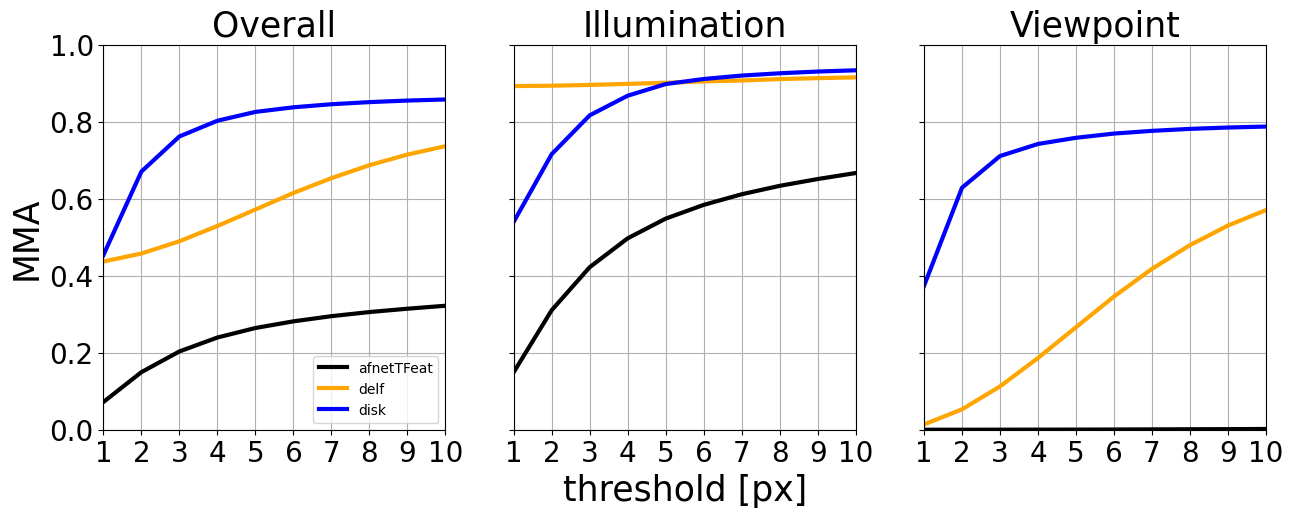

In [187]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 1])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Illumination')
plt.xlabel('threshold [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Viewpoint')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 1])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

# plt.savefig('hseq-top.pdf', bbox_inches='tight', dpi=300)